# Testing Predictions of the variants of MILD

v1_1/diaghmm_z3h5 100	3.3062e-03 ± 4.0426e-03 	1.1037e-03 ± 8.1811e-04
v2_1/diaghmm_z3h5 100	3.2887e-03 ± 4.0806e-03 	1.0944e-03 ± 8.5014e-04
v2_2/diaghmm_z3h5 100	3.2853e-03 ± 4.1741e-03 	1.0939e-03 ± 8.2047e-04
v3_1/diaghmm_z3h5 100	3.4537e-03 ± 4.1227e-03 	1.1919e-03 ± 8.5463e-04
v3_2/diaghmm_z3h5 100	3.2837e-03 ± 4.0811e-03 	1.1580e-03 ± 8.5286e-04
v4_1/diaghmm_z3h5 100	3.3201e-03 ± 4.0605e-03 	1.1305e-03 ± 8.2167e-04
v4_2/diaghmm_z3h5 100	3.2803e-03 ± 4.1187e-03 	1.1365e-03 ± 8.7073e-04


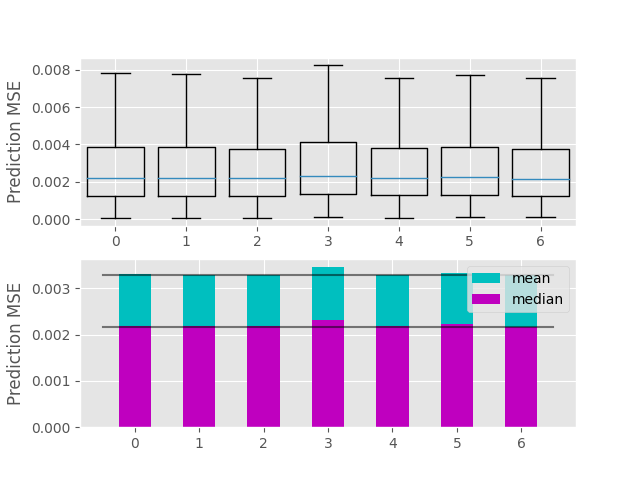

In [1]:
%matplotlib widget
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import os

from mild_hri.utils import *
from mild_hri.dataloaders import *


os.environ['CUDA_VISIBLE_DEVICES'] = '0'

fig = plt.figure()
plt.title('MSE of predicted robot joints after observing human')
ax_box_pred = plt.subplot(2,1,1)
# ax_box_vae = plt.subplot(2,2,2)
ax_bar_pred = plt.subplot(2,1,2)
# ax_bar_vae = plt.subplot(2,2,4)
k = 0

pred_mse = []
labels = []
vae_mse = []
for model_type in [
					'v1_1/diaghmm_z3h5',
					'v2_1/diaghmm_z3h5',
					'v2_2/diaghmm_z3h5',
					'v3_1/diaghmm_z3h5',
					'v3_2/diaghmm_z3h5',
					'v4_1/diaghmm_z3h5',
					'v4_2/diaghmm_z3h5',
				]:
	# for epoch in range(50,401,50):
	for epoch in [100]:
		pred_mse_k = []
		vae_mse_k = []
		for trial in range(4):
			if epoch == 400:
				ckpt_path = f'../logs/2023/bp_hh_20hz/{model_type}/trial{trial}/models/final_399.pth'
			else:
				ckpt_path = f'../logs/2023/bp_hh_20hz/{model_type}/trial{trial}/models/' + '%0.3d'%epoch + '.pth'
	
			ckpt = torch.load(ckpt_path)
			pred_mse_ckpt, vae_mse_ckpt = evaluate_ckpt_hh(ckpt_path)
			if np.any(np.isnan(pred_mse_ckpt)):
				print(model_type, trial)
				continue
			pred_mse_k += pred_mse_ckpt
			vae_mse_k += vae_mse_ckpt
		pred_mse.append(pred_mse_k)
		vae_mse.append(vae_mse_k)
		print(f'{model_type} {epoch}\t{np.mean(pred_mse_k):.4e} ± {np.std(pred_mse_k):.4e} \t{np.mean(vae_mse_k):.4e} ± {np.std(vae_mse_k):.4e}')
	

# p_values = np.ones((len(pred_mse), len(pred_mse)))
# for i in range(len(pred_mse)-1):
#     for j in range(i+1,len(pred_mse)):
#         p_values[i,j] = scipy.stats.ttest_ind(pred_mse[i], pred_mse[j]).pvalue
#         print(i,j,p_values[i,j])

# p_values = np.ones((len(pred_mse), len(pred_mse)))
# for i in range(len(pred_mse)-1):
#     for j in range(i+1,len(pred_mse)):
#         p_values[i,j] = scipy.stats.ttest_rel(pred_mse[i], pred_mse[j]).pvalue
#         print(i,j,p_values[i,j])

# p_values = np.ones((len(pred_mse), len(pred_mse)))
# for i in range(len(pred_mse)-1):
#     for j in range(i+1,len(pred_mse)):
#         p_values[i,j] = scipy.stats.mannwhitneyu(pred_mse[i], pred_mse[j]).pvalue
#         print(i,j,p_values[i,j])


X = np.arange(len(pred_mse))
mean_pred_mse = np.array([np.mean(pred_mse[i]) for i in range(len(pred_mse))])
med_pred_mse = np.array([np.median(pred_mse[i]) for i in range(len(pred_mse))])
ax_bar_pred.bar(X, mean_pred_mse, color = 'c', width = 0.5, label='mean')#, label='100 epochs')
ax_bar_pred.bar(X, med_pred_mse, color = 'm', width = 0.5, label='median')#, label='100 epochs')

ax_bar_pred.plot([X[0]-0.5, X[-1]+0.5], [mean_pred_mse.min(), mean_pred_mse.min()], 'k-', alpha = 0.5)#, label='100 epochs')
ax_bar_pred.plot([X[0]-0.5, X[-1]+0.5], [med_pred_mse.min(), med_pred_mse.min()], 'k-', alpha = 0.5)#, label='100 epochs')


# for i in [0.085, 0.095]:
# 	ax_bar_pred.plot([-0.3,len(pred_mse)-0.7], [i,i], 'k--',alpha=0.2)
# for i in range(len(mean_pred_mse)):
# 	ax_bar_pred.text(i-0.25, mean_pred_mse[i]+0.003, f'{mean_pred_mse[i]:.4f}')
for i in range(len(pred_mse)):
	ax_box_pred.boxplot(pred_mse[i], positions=[i], showfliers=False, widths=[0.8])
# ax_bar_pred.bar(X + 0.6, [np.mean(pred_mse[i][1]) for i in range(len(pred_mse))], color = 'm', width = 0.2, label='200 Epochs')
ax_bar_pred.set_ylabel('Prediction MSE')
ax_box_pred.set_ylabel('Prediction MSE')
# ax_bar_pred.set_xticks(X, ('MILD', 'Cond. Samples', 'Cond. Samples\nwith Post. Cov.', 'Diagonalized\nCond. Samples', 'Diagonalized\nCond. Samples\nwith Post. Cov.', 'Post. Samples\nConditioning', 'Post. Samples\nConditioning\nwith Post. Cov.', ))
# ax_box_pred.set_xticks(X, ('MILD', 'Cond. Samples', 'Cond. Samples\nwith Post. Cov.', 'Diagonalized\nCond. Samples', 'Diagonalized\nCond. Samples\nwith Post. Cov.', 'Post. Samples\nConditioning', 'Post. Samples\nConditioning\nwith Post. Cov.', ))
# ax_bar_pred.set_xticks(X, ('MILD', '#2.1', '#2.2', '#3.1', '#3.2', '#4.1', '#4.2'))
# ax_box_pred.set_xticks(X, ('MILD', '#2.1', '#2.2', '#3.1', '#3.2', '#4.1', '#4.2'))
# for i in [0.2,0.225]:
# 	ax_box_pred.plot([-0.5,len(pred_mse)-0.5], [i,i], 'k--',alpha=0.2)
# for i in [0.05, 0.04]:
# 	ax_bar_pred.plot([-0.3,len(pred_mse)-0.7], [i,i], 'k--',alpha=0.5)
ax_bar_pred.legend()
# ax_bar_pred.set_ylim(top=0.21)


# 100 epochs hh with waving
# v1_1/diaghmm_z3h5 100	4.2367e-03 ± 6.2869e-03 	1.2224e-03 ± 8.6947e-04
# v2_1/diaghmm_z3h5 100	4.2156e-03 ± 6.3374e-03 	1.2241e-03 ± 9.0192e-04
# v2_2/diaghmm_z3h5 100	4.1929e-03 ± 6.3737e-03 	1.2283e-03 ± 8.8580e-04
# v3_1/diaghmm_z3h5 100	4.3807e-03 ± 6.4302e-03 	1.2859e-03 ± 8.8117e-04
# v3_2/diaghmm_z3h5 100	4.2122e-03 ± 6.3869e-03 	1.2634e-03 ± 8.9371e-04
# v4_1/diaghmm_z3h5 100	4.2876e-03 ± 6.3639e-03 	1.2594e-03 ± 8.8222e-04
# v4_2/diaghmm_z3h5 100	4.2461e-03 ± 6.2697e-03 	1.2510e-03 ± 9.0307e-04

# 100 epochs hh without waving
# v1_1/diaghmm_z3h5 100	3.3062e-03 ± 4.0426e-03 	1.1037e-03 ± 8.1811e-04
# v2_1/diaghmm_z3h5 100	3.2887e-03 ± 4.0806e-03 	1.0944e-03 ± 8.5014e-04
# v2_2/diaghmm_z3h5 100	3.2853e-03 ± 4.1741e-03 	1.0939e-03 ± 8.2047e-04
# v3_1/diaghmm_z3h5 100	3.4537e-03 ± 4.1227e-03 	1.1919e-03 ± 8.5463e-04
# v3_2/diaghmm_z3h5 100	3.2837e-03 ± 4.0811e-03 	1.1580e-03 ± 8.5286e-04
# v4_1/diaghmm_z3h5 100	3.3201e-03 ± 4.0605e-03 	1.1305e-03 ± 8.2167e-04
# v4_2/diaghmm_z3h5 100	3.2803e-03 ± 4.1187e-03 	1.1365e-03 ± 8.7073e-04


# 400 epochs bp_pepper_20hz without waving
# v1_1/diaghmm_z3h5 400	1.3569e-01 ± 2.5281e-01 	8.7684e-03 ± 8.8397e-03
# v2_1/diaghmm_z3h5 400	5.2659e-02 ± 9.6123e-02 	1.1217e-02 ± 1.0335e-02
# v2_2/diaghmm_z3h5 400	5.8945e-02 ± 1.1318e-01 	1.1852e-02 ± 1.1038e-02
# v3_1/diaghmm_z3h5 400	5.1885e-02 ± 9.5199e-02 	1.3948e-02 ± 1.4626e-02
# v3_2/diaghmm_z3h5 400	5.0402e-02 ± 9.2115e-02 	1.4135e-02 ± 1.4213e-02
# v4_1/diaghmm_z3h5 400	5.0746e-02 ± 9.1155e-02 	1.4699e-02 ± 1.4931e-02
# v4_2/diaghmm_z3h5 400	5.1632e-02 ± 8.8643e-02 	1.3974e-02 ± 1.2725e-02

# 400 epochs bp_pepper_20hz with waving
# v1_1/diaghmm_z3h5 400	2.6365e-01 ± 3.3649e-01 	1.0818e-02 ± 1.0526e-02
# v2_1/diaghmm_z3h5 400	1.2379e-01 ± 1.9195e-01 	1.3779e-02 ± 1.1862e-02
# v2_2/diaghmm_z3h5 400	1.1074e-01 ± 1.6144e-01 	1.4567e-02 ± 1.2600e-02
# v3_1/diaghmm_z3h5 400	7.1058e-02 ± 1.1302e-01 	1.6456e-02 ± 1.4895e-02
# v3_2/diaghmm_z3h5 400	7.0113e-02 ± 1.1113e-01 	1.8800e-02 ± 1.9126e-02
# v4_1/diaghmm_z3h5 400	7.0829e-02 ± 1.0957e-01 	1.8129e-02 ± 1.6469e-02
# v4_2/diaghmm_z3h5 400	7.1232e-02 ± 1.0835e-01 	1.6803e-02 ± 1.3736e-02


# 400 epochs bp_pepper_20hz_norm without waving
# v1_1/diaghmm_z3h5 400	1.3201e-01 ± 2.1314e-01 	3.5618e-01 ± 6.5011e-02
# v2_1/diaghmm_z3h5 400	5.4312e-02 ± 9.9336e-02 	3.3811e-01 ± 6.3651e-02
# v2_2/diaghmm_z3h5 400	5.6130e-02 ± 9.9796e-02 	3.5284e-01 ± 6.8692e-02
# v3_1/diaghmm_z3h5 400	5.1554e-02 ± 9.3804e-02 	3.5053e-01 ± 7.5379e-02
# v3_2/diaghmm_z3h5 400	5.2122e-02 ± 9.6390e-02 	3.4979e-01 ± 7.5908e-02
# v4_1/diaghmm_z3h5 400	5.3562e-02 ± 9.3032e-02 	3.4333e-01 ± 6.9881e-02
# v4_2/diaghmm_z3h5 400	5.1502e-02 ± 9.2522e-02 	3.4764e-01 ± 7.4388e-02

# 400 epochs bp_pepper_20hz_norm with waving
# v1_1/diaghmm_z3h5 400	2.3392e-01 ± 2.9343e-01 	3.8798e-01 ± 9.4358e-02
# v2_1/diaghmm_z3h5 400	8.8631e-02 ± 1.3771e-01 	3.7012e-01 ± 9.3612e-02
# v2_2/diaghmm_z3h5 400	9.6987e-02 ± 1.4393e-01 	3.8232e-01 ± 9.3902e-02
# v3_1/diaghmm_z3h5 400	7.1857e-02 ± 1.1109e-01 	3.8798e-01 ± 1.0401e-01
# v3_2/diaghmm_z3h5 400	7.2003e-02 ± 1.1223e-01 	3.8462e-01 ± 1.0171e-01
# v4_1/diaghmm_z3h5 400	7.4166e-02 ± 1.1058e-01 	3.8016e-01 ± 1.0060e-01
# v4_2/diaghmm_z3h5 400	7.1250e-02 ± 1.0856e-01 	3.8716e-01 ± 1.0606e-01


# "MILD" - Standard VAE Loss
$$\mathcal{L}_t = \mathbb{E}_{q_h}\log p(\boldsymbol{x}^h_t|\boldsymbol{z}^h_t) + \mathbb{E}_{q_r}\log p(\boldsymbol{x}^r_t|\boldsymbol{z}^r_t) + \mathcal{L}_{KL}$$

The following  use an additional conditional reconstruction term $\mathcal{L}_{cond} = \mathbb{E}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)$
They mainly differ in how the expectation is calculated w.r.t $\boldsymbol{\hat{z}}^r_t$, specifically which distribution is used for Monte Carlo sampling. We then calculate the reconstruction loss for the sampled points.

# Cond. Samples
- Samples are drawn from the HMM conditional distribution.
- Calculate the posterior distribution $\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t),\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t) = q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)$
- Calculate the conditional distribution using the posterior mean and sample $\boldsymbol{\hat{z}}^r_t$ from this.
$$
  \boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{\mu}}^r_i = {\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})\\
    \boldsymbol{\hat{\Sigma}}^r_i = {\color{orange}\boldsymbol{\Sigma}^{rr}_i} - \boldsymbol{K}_i{\color{orange}\boldsymbol{\Sigma}^{hr}_i} + \boldsymbol{\hat{\mu}}^r_i(\boldsymbol{\hat{\mu}}^r_i)^T\\
    \boldsymbol{\hat{\mu}}^r_t = \sum_{i=1}^N {\color{orange}\bar \alpha_i^t} \hspace{0.2em} \boldsymbol{\hat{\mu}}^r_i\\
    \boldsymbol{\hat{\Sigma}}^r_t = \left[\sum_{i=1}^N {\color{orange}\bar \alpha_i^t} \hspace{0.2em} \boldsymbol{\hat{\Sigma}}^r_i\right]  - \boldsymbol{\hat{\mu}}^r_t(\boldsymbol{\hat{\mu}}^r_t)^T\\
    p(\boldsymbol{z}_t^r | q_t^h) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, \boldsymbol{\hat{\Sigma}}^r_t) \\
    \mathcal{L}_{cond} = \mathbb{E}_{\boldsymbol{\hat{z}}^r_t \sim p(\boldsymbol{z}_t^r | q_t^h)}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)
$$

# Diagonalized Cond. Samples
Same as above but using the diagonalized form of the conditional distribution covariance
$$p(\boldsymbol{z}_t^r | q_t^h) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, diag(\boldsymbol{\hat{\Sigma}}^r_t))$$

# Posterior Sample Conditioning 
$$
{\color{magenta}\boldsymbol{z}^h_t} \sim q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)\\
\boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{z}}^r_t = \sum_{k=1}^K {\color{orange}\bar \alpha_i^t} [{\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{z}^h_t})]\\
    \mathcal{L}_{cond} = \mathbb{E}_{\boldsymbol{\hat{z}}^r_t| \boldsymbol{z}^h_t \sim q(\boldsymbol{z}^h_t | \boldsymbol{x}^h_t)}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)
$$


# "with Post. Cov."
This implies Conditioning with the Posterior Covariance
$$\boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i} + {\color{magenta}\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})^{-1}$$